# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [25]:
# import libraries
import sys
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.externals import joblib
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from  sklearn.pipeline import make_pipeline


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
# load data from database
engine = create_engine('sqlite:///InsertDatabaseName.db')
df = pd.read_sql_table('CleanTable', engine)
X = df[["message", "genre"]]
Y = df.drop(axis=1, labels=["id", "message", "original", "genre"])
category_names = list(df.columns[4:])

### 2. Write a tokenization function to process your text data

In [27]:
def tokenize(text):
    clean_token_arr = []
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9]", "", text)
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    for token in tokens:
        clean_token = lemmatizer.lemmatize(token).strip()
        clean_token_arr.append(clean_token)
    
    return clean_token_arr

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [29]:
def build_model():
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier()))
        ])
    '''
      parameters = {'clf__estimator__n_estimators': [50,20],
                  'clf__estimator__min_samples_split': [50,20],
                  'clf__estimator__criterion': ['entropy', 'gini']
                 }    
    cv = GridSearchCV(pipeline, param_grid=parameters)  
    '''

    return pipeline

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X['message'], Y, test_size=0.2)
model = build_model()
model.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [31]:
def plot_scores(y, y_pred):
    
    f1_series = pd.Series()
    
    for i_col in range(y.shape[1]):
        print(y.columns[i_col])
        print(classification_report(y.iloc[:,i_col], y_pred[:,i_col]))
        f1_series[y.columns[i_col]] = f1_score(y.iloc[:,i_col], y_pred[:,i_col], average='weighted')
    plt.figure(figsize=[12,6])
    f1_series.sort_values(ascending=False).plot(kind="bar" )
    print("f1 score mean : ", f1_series.mean())

related
             precision    recall  f1-score   support

          0       0.75      0.00      0.01      1201
          1       0.83      0.00      0.00      3989
          2       0.01      0.98      0.02        46

avg / total       0.81      0.01      0.01      5236

request
             precision    recall  f1-score   support

          0       0.83      1.00      0.91      4332
          1       0.00      0.00      0.00       904

avg / total       0.68      0.83      0.75      5236

offer
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5211
          1       0.00      0.00      0.00        25

avg / total       0.99      1.00      0.99      5236

aid_related
             precision    recall  f1-score   support

          0       0.59      1.00      0.74      3075
          1       0.60      0.00      0.00      2161

avg / total       0.59      0.59      0.44      5236

medical_help
             precision    recall  f1-sco

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 score mean :  0.876307320977


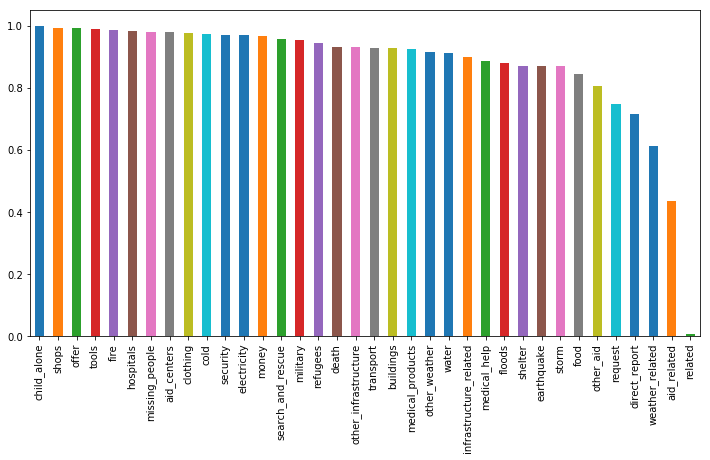

In [32]:
Y_test_pred = model.predict(X_test)
plot_scores(Y_test, Y_test_pred)

### 6. Improve your model
Use grid search to find better parameters. 

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X['message'], Y, random_state=42)

pipeline2 = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", MultiOutputClassifier(LogisticRegression()))])
pipeline2.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
           n_jobs=1))])

In [40]:

parameters = {
    "vect__max_features" : [None, 5000, 10000],
    "clf__estimator__C" : [0.1,1,10]
    }
cv = GridSearchCV(pipeline2, param_grid=parameters, n_jobs=-1, cv=2)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

related
             precision    recall  f1-score   support

          0       0.69      0.01      0.01      1568
          1       0.75      1.00      0.86      4930
          2       0.00      0.00      0.00        47

avg / total       0.73      0.75      0.65      6545

request
             precision    recall  f1-score   support

          0       0.83      1.00      0.91      5411
          1       1.00      0.00      0.00      1134

avg / total       0.86      0.83      0.75      6545

offer
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6513
          1       0.00      0.00      0.00        32

avg / total       0.99      1.00      0.99      6545

aid_related
             precision    recall  f1-score   support

          0       0.58      1.00      0.74      3825
          1       1.00      0.00      0.00      2720

avg / total       0.76      0.58      0.43      6545

medical_help
             precision    recall  f1-sco

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 score mean :  0.890558183325


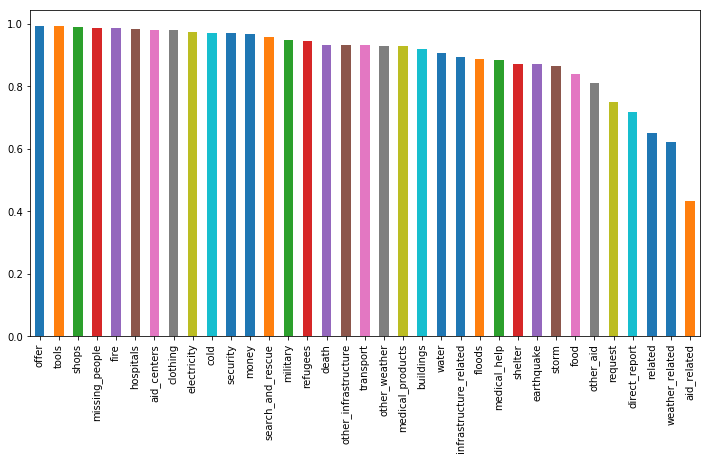

In [41]:
cv.fit(X_train, Y_train)
Y_test_pred = cv.predict(X_test)
plot_scores(Y_test, Y_test_pred)

In [42]:
cv.grid_scores_, cv.best_params_, cv.best_score_

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.19537, std: 0.00162, params: {'clf__estimator__C': 0.1, 'vect__max_features': None},
  mean: 0.19537, std: 0.00162, params: {'clf__estimator__C': 0.1, 'vect__max_features': 5000},
  mean: 0.19537, std: 0.00162, params: {'clf__estimator__C': 0.1, 'vect__max_features': 10000},
  mean: 0.19537, std: 0.00172, params: {'clf__estimator__C': 1, 'vect__max_features': None},
  mean: 0.19537, std: 0.00172, params: {'clf__estimator__C': 1, 'vect__max_features': 5000},
  mean: 0.19537, std: 0.00172, params: {'clf__estimator__C': 1, 'vect__max_features': 10000},
  mean: 0.19643, std: 0.00167, params: {'clf__estimator__C': 10, 'vect__max_features': None},
  mean: 0.19623, std: 0.00167, params: {'clf__estimator__C': 10, 'vect__max_features': 5000},
  mean: 0.19643, std: 0.00167, params: {'clf__estimator__C': 10, 'vect__max_features': 10000}],
 {'clf__estimator__C': 10, 'vect__max_features': None},
 0.19643493761140821)

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [49]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

class BasicTextAnalytics(BaseEstimator, TransformerMixin):
    '''
    Class for returning some basic numerical data for text analysis to include in 
    modelling. Such as: 
    - Number of sentences
    - Number of words
    - Number of nouns
    - Number of verbs
    - Number of adjectives
    A lot of the above were taken from ideas found here: 
    https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/
    '''
    pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
    }

    # function to check and get the part of speech tag count of a words in a given sentence
    def check_pos_tag(self, text, flag):
        '''
        Returns the count of a given NL pos_tag, based on user selection. E.g. number of nouns.
        INPUTS
        text - the given text to analyse
        flag - pos family to analyse, one of 'noun', 'pron' , 'verb', 'adj' or 'adv'
        '''
        count = 0
        try:
            wiki = textblob.TextBlob(text)
            for tup in wiki.tags:
                ppo = list(tup)[1]
                if ppo in pos_family[flag]:
                    count += 1
        except:
            pass
        return count
    
    def fit(self, x, y=None):
        return self

    def transform(self, X):
        trainDF = pd.DataFrame()
        trainDF['text'] = X
        trainDF['word_count'] = trainDF['text'].apply(lambda x: len(x.split()))
        trainDF['title_word_count'] = trainDF['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
        trainDF['noun_count'] = trainDF['text'].apply(lambda x: self.check_pos_tag(x, 'noun'))
        trainDF['verb_count'] = trainDF['text'].apply(lambda x: self.check_pos_tag(x, 'verb'))
        trainDF['adj_count'] = trainDF['text'].apply(lambda x: self.check_pos_tag(x, 'adj'))
        trainDF['adv_count'] = trainDF['text'].apply(lambda x: self.check_pos_tag(x, 'adv'))
        trainDF['pron_count'] = trainDF['text'].apply(lambda x: self.check_pos_tag(x, 'pron'))
        
        return trainDF.drop('text',axis=1)

    
pipeline_model = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),

        ('numerical_pipeline', Pipeline([
            ('analytics', BasicTextAnalytics()),
            ('norm', StandardScaler())
            ]))
    ])),

    ('clf', MultiOutputClassifier(LogisticRegression()))
])
# specify parameters for grid search

parameters = {
    'features__text_pipeline__vect__max_features' : [None],
    'clf__estimator__C': [10]
}

grid_cv_search = GridSearchCV(pipeline_model, parameters, n_jobs=-1, cv=2)
sorted(pipeline_model.get_params().keys())

['clf',
 'clf__estimator',
 'clf__estimator__C',
 'clf__estimator__class_weight',
 'clf__estimator__dual',
 'clf__estimator__fit_intercept',
 'clf__estimator__intercept_scaling',
 'clf__estimator__max_iter',
 'clf__estimator__multi_class',
 'clf__estimator__n_jobs',
 'clf__estimator__penalty',
 'clf__estimator__random_state',
 'clf__estimator__solver',
 'clf__estimator__tol',
 'clf__estimator__verbose',
 'clf__estimator__warm_start',
 'clf__n_jobs',
 'features',
 'features__n_jobs',
 'features__numerical_pipeline',
 'features__numerical_pipeline__analytics',
 'features__numerical_pipeline__memory',
 'features__numerical_pipeline__norm',
 'features__numerical_pipeline__norm__copy',
 'features__numerical_pipeline__norm__with_mean',
 'features__numerical_pipeline__norm__with_std',
 'features__numerical_pipeline__steps',
 'features__text_pipeline',
 'features__text_pipeline__memory',
 'features__text_pipeline__steps',
 'features__text_pipeline__tfidf',
 'features__text_pipeline__tfidf__nor

In [50]:
grid_cv_search.fit(X_train, Y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_d...None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'features__text_pipeline__vect__max_features': [None], 'clf__estimator__C': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

related
             precision    recall  f1-score   support

          0       0.69      0.01      0.01      1568
          1       0.75      1.00      0.86      4930
          2       0.00      0.00      0.00        47

avg / total       0.73      0.75      0.65      6545

request
             precision    recall  f1-score   support

          0       0.83      1.00      0.91      5411
          1       1.00      0.00      0.00      1134

avg / total       0.86      0.83      0.75      6545

offer
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6513
          1       0.00      0.00      0.00        32

avg / total       0.99      1.00      0.99      6545

aid_related
             precision    recall  f1-score   support

          0       0.61      0.91      0.73      3825
          1       0.58      0.17      0.26      2720

avg / total       0.59      0.60      0.54      6545

medical_help
             precision    recall  f1-sco

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 score mean :  0.895350607536


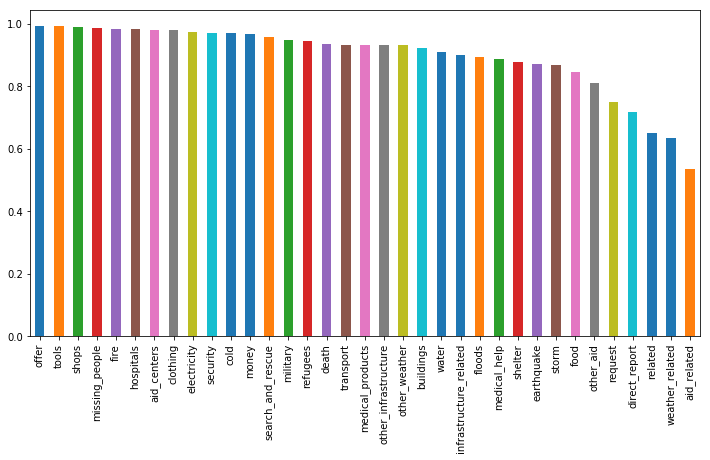

In [55]:
# scores of test data
Y_test_pred = grid_cv_search.predict(X_test)
plot_scores(Y_test, Y_test_pred)

## result conlude
|model|average f1 score|
|:----|:----|
|Random Forest|0.929|
|Logistic Regresion|0.936|
|Logistic Regresion + GridSearch|0.9399|

### 9. Export your model as a pickle file

In [54]:
import pickle

with open("classifier.pkl", 'wb') as file:
    pickle.dump(cv, file)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.